In [245]:
# ============================================================
# Olist E-commerce EDA (Colab-ready)
# - Load Olist datasets
# - Basic cleaning / validation
# - Bundle cleaned tables into `clean` dict
# ============================================================

# 1) Setup and imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# 2) Load data (simple and explicit)
DATA_DIR = r"C:\Users\mg441\olist_eda\data"  # <- change if your files are elsewhere

def load_csv(filename: str) -> pd.DataFrame:
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Cannot find {filename} at {path}. "
            f"Upload CSVs to {DATA_DIR} or update DATA_DIR."
        )
    return pd.read_csv(path)

orders = load_csv("olist_orders_dataset.csv")
customers = load_csv("olist_customers_dataset.csv")
order_items = load_csv("olist_order_items_dataset.csv")
payments = load_csv("olist_order_payments_dataset.csv")
reviews = load_csv("olist_order_reviews_dataset.csv")
products = load_csv("olist_products_dataset.csv")
sellers = load_csv("olist_sellers_dataset.csv")
geolocation = load_csv("olist_geolocation_dataset.csv")

print("orders", orders.shape)
print("customers", customers.shape)
print("order_items", order_items.shape)
print("payments", payments.shape)
print("reviews", reviews.shape)
print("products", products.shape)
print("sellers", sellers.shape)
print("geolocation", geolocation.shape)

# 3) Review cleanup (simple version)
# If the same order has identical score/text, keep only one record.
reviews_dedup = reviews.copy()

# Make sure timestamps are proper datetime
reviews_dedup["review_answer_timestamp"] = pd.to_datetime(
    reviews_dedup["review_answer_timestamp"], errors="coerce"
)

# Sort so the latest review stays when duplicates exist
reviews_dedup = reviews_dedup.sort_values("review_answer_timestamp")

# Remove exact duplicates by order + content + score
reviews_dedup = reviews_dedup.drop_duplicates(
    subset=["order_id", "review_score", "review_comment_title", "review_comment_message"],
    keep="last",
)

print("reviews before:", len(reviews))
print("reviews after dedup:", len(reviews_dedup))

# 4) Order date cleanup (simple version)
# If a later date happens before an earlier date, set the later one to NaT.
orders_fix = orders.copy()

# Parse dates
orders_fix["order_purchase_timestamp"] = pd.to_datetime(
    orders_fix["order_purchase_timestamp"], errors="coerce"
)
orders_fix["order_approved_at"] = pd.to_datetime(orders_fix["order_approved_at"], errors="coerce")
orders_fix["order_delivered_carrier_date"] = pd.to_datetime(
    orders_fix["order_delivered_carrier_date"], errors="coerce"
)
orders_fix["order_delivered_customer_date"] = pd.to_datetime(
    orders_fix["order_delivered_customer_date"], errors="coerce"
)
orders_fix["order_estimated_delivery_date"] = pd.to_datetime(
    orders_fix["order_estimated_delivery_date"], errors="coerce"
)

# Flags
orders_fix["flag_approved_gt_carrier"] = (
    orders_fix["order_approved_at"] > orders_fix["order_delivered_carrier_date"]
)
orders_fix["flag_carrier_gt_delivered"] = (
    orders_fix["order_delivered_carrier_date"] > orders_fix["order_delivered_customer_date"]
)

# Fix impossible sequences
orders_fix.loc[orders_fix["flag_approved_gt_carrier"], "order_delivered_carrier_date"] = pd.NaT
orders_fix.loc[orders_fix["flag_carrier_gt_delivered"], "order_delivered_customer_date"] = pd.NaT

# Lead times (hours)
orders_fix["lead_purchase_to_approved_hr"] = (
    (orders_fix["order_approved_at"] - orders_fix["order_purchase_timestamp"])
    .dt.total_seconds()
    / 3600
)

orders_fix["lead_approved_to_carrier_hr"] = (
    (orders_fix["order_delivered_carrier_date"] - orders_fix["order_approved_at"])
    .dt.total_seconds()
    / 3600
)

orders_fix["lead_carrier_to_delivered_hr"] = (
    (orders_fix["order_delivered_customer_date"] - orders_fix["order_delivered_carrier_date"])
    .dt.total_seconds()
    / 3600
)

orders_fix["lead_purchase_to_delivered_hr"] = (
    (orders_fix["order_delivered_customer_date"] - orders_fix["order_purchase_timestamp"])
    .dt.total_seconds()
    / 3600
)

orders_fix["delay_days"] = (
    orders_fix["order_delivered_customer_date"] - orders_fix["order_estimated_delivery_date"]
).dt.days

print("approved>carrier flagged:", int(orders_fix["flag_approved_gt_carrier"].sum()))
print("carrier>delivered flagged:", int(orders_fix["flag_carrier_gt_delivered"].sum()))

# 5) Product cleanup (simple version)
# Fill missing categories and set invalid weights to NaN.
products_fix = products.copy()

products_fix["product_category_name"] = products_fix["product_category_name"].fillna("Unknown")
products_fix["product_category_name"] = products_fix["product_category_name"].astype(str).str.strip()
products_fix.loc[products_fix["product_category_name"] == "", "product_category_name"] = "Unknown"

products_fix.loc[products_fix["product_weight_g"] <= 0, "product_weight_g"] = pd.NA

print("Unknown category:", int((products_fix["product_category_name"] == "Unknown").sum()))
print("weight NaN:", int(products_fix["product_weight_g"].isna().sum()))

# 6) Payment cleanup (simple version)
# Flag non-positive payment values and keep a positive-only view.
payments_fix = payments.copy()
payments_fix["flag_payment_le_0"] = payments_fix["payment_value"] <= 0

payments_pos = payments_fix[payments_fix["payment_value"] > 0].copy()

print("payments total:", len(payments_fix))
print("payments <= 0:", int(payments_fix["flag_payment_le_0"].sum()))
print("payments_pos:", len(payments_pos))

# 7) Geolocation cleanup (simple version)
# Aggregate by zip prefix and keep representative city/state.
geo = geolocation.copy()

geolocation_fix = geo.groupby("geolocation_zip_code_prefix").agg(
    geolocation_lat=("geolocation_lat", "mean"),
    geolocation_lng=("geolocation_lng", "mean"),
    geolocation_city=("geolocation_city", lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]),
    geolocation_state=("geolocation_state", lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]),
    count=("geolocation_city", "size"),
).reset_index()

print("geolocation_fix:", geolocation_fix.shape)

# 8) Payment vs item totals check (simple version)
# Count orders with large discrepancies (abs delta > 100).
items_tot = order_items.groupby("order_id").agg(
    items_total=("price", "sum"),
    freight_total=("freight_value", "sum"),
)
items_tot["items_plus_freight"] = items_tot["items_total"] + items_tot["freight_total"]

pay_tot = payments.groupby("order_id").agg(payment_total=("payment_value", "sum"))

compare = items_tot.join(pay_tot, how="inner")
compare["delta"] = compare["payment_total"] - compare["items_plus_freight"]

large_delta = compare[compare["delta"].abs() > 100]
print("large deltas (abs>100):", len(large_delta))

# 9) Final cleaned dataset bundle
clean = {
    "orders": orders_fix,
    "customers": customers,
    "order_items": order_items,
    "payments": payments_fix,
    "payments_pos": payments_pos,
    "reviews": reviews_dedup,
    "products": products_fix,
    "sellers": sellers,
    "geolocation": geolocation_fix,
}

for k, v in clean.items():
    print(k, v.shape)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [246]:
# 1) 파일 불러오기
products = pd.read_csv("C:/Users/mg441/olist_eda/data/olist_products_dataset.csv")
cat_trans = pd.read_csv("C:/Users/mg441/olist_eda/data/product_category_name_translation.csv")

# 2) 열 이름 확인 (혹시 encoding 이슈 있으면)
print(cat_trans.columns)

# 3) 병합 (merge)
products = products.merge(
    cat_trans,
    how="left",
    on="product_category_name"
)

# 4) 영어 이름으로 컬럼 정리
products["product_category_name_english"] = (
    products["product_category_name_english"]
    .fillna("unknown")
)

# (선택) 기존 포르투갈어 컬럼을 지우고 영어만 사용
# products = products.drop(columns=["product_category_name"])


Index(['product_category_name', 'product_category_name_english'], dtype='object')


In [247]:
for name, df in clean.items():
    print(f"\n===== {name.upper()} =====")
    display(df.head())


===== ORDERS =====


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,flag_approved_gt_carrier,flag_carrier_gt_delivered,lead_purchase_to_approved_hr,lead_approved_to_carrier_hr,lead_carrier_to_delivered_hr,lead_purchase_to_delivered_hr,delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,False,0.178333,56.795833,145.503611,202.477778,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,False,False,30.713889,11.109167,288.945833,330.768889,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,False,False,0.276111,4.910278,220.274722,225.461111,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,False,False,0.298056,89.900000,226.811944,317.010000,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,False,False,1.030556,21.434722,46.507778,68.973056,-10.0



===== CUSTOMERS =====


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



===== ORDER_ITEMS =====


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



===== PAYMENTS =====


,order_id,payment_sequential,payment_type,payment_installments,payment_value,flag_payment_le_0
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,False
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,False
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,False
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,False
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,False



===== PAYMENTS_POS =====


,order_id,payment_sequential,payment_type,payment_installments,payment_value,flag_payment_le_0
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,False
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,False
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,False
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,False
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,False



===== REVIEWS =====


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
37547,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,NaN,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28
5503,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,NaN,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29
60439,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,NaN,NaN,2016-10-15 00:00:00,2016-10-16 03:20:17
28075,53752edb26544dd41c1209f582c9c589,b8b9d7046c083150cb5360b83a8ebb51,5,NaN,O pedido foi entregue antes do prazo pr0metido,2016-10-16 01:00:00,2016-10-16 15:45:11
41042,b2d5d8db2a841d27a72e4c06c6212368,9aa3197e4887919fde0307fc23601d7a,4,NaN,Só chegou uma parte do pedido ate agora..,2016-10-15 00:00:00,2016-10-17 21:02:49



===== PRODUCTS =====


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0



===== SELLERS =====


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP



===== GEOLOCATION =====


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,count
0,1001,-23.550190,-46.634024,sao paulo,SP,26
1,1002,-23.548146,-46.634979,sao paulo,SP,13
2,1003,-23.548994,-46.635731,sao paulo,SP,17
3,1004,-23.549799,-46.634757,sao paulo,SP,22
4,1005,-23.549456,-46.636733,sao paulo,SP,25


In [248]:
industry_map = {
     # Home & Living
    "bed_bath_table": "Home & Living",
    "furniture_decor": "Home & Living",
    "office_furniture": "Home & Living",
    "furniture_living_room": "Home & Living",
    "housewares": "Home & Living",
    "home_construction": "Home & Living",
    "garden_tools": "Home & Living",

    # Tech & Electronics
    "computers_accessories": "Tech & Electronics",
    "pcs": "Tech & Electronics",
    "telephony": "Tech & Electronics",
    "home_appliances": "Tech & Electronics",
    "small_appliances": "Tech & Electronics",
    "air_conditioning": "Tech & Electronics",
    "electronics": "Tech & Electronics",
    "consoles_games": "Tech & Electronics",

    # Health & Beauty
    "perfumery": "Health & Beauty",
    "health_beauty": "Health & Beauty",

    # Sports & Leisure
    "sports_leisure": "Sports & Leisure",
    "musical_instruments": "Sports & Leisure",
    "art": "Sports & Leisure",

    # Fashion & Accessories
    "watches_gifts": "Fashion & Accessories",
    "luggage_accessories": "Fashion & Accessories",
    "fashion_bags_accessories": "Fashion & Accessories",
    "fashion_shoes": "Fashion & Accessories",

    # Kids & Toys
    "baby": "Kids & Toys",
    "toys": "Kids & Toys",

    # Automotive
    "auto": "Automotive",

    # 🔥 새로 분리
    "stationery": "Life Goods",
    "books_general_interest": "Life Goods",
    "cool_stuff": "Life Goods",

    "pet_shop": "Pet & Agro",
    "agro_industry_and_commerce": "Pet & Agro",

    "construction_tools_safety": "Construction & Safety",
    "signaling_and_security": "Construction & Safety",
}

products_fix=products
products_fix["industry"] = (
    products_fix["product_category_name_english"]
    .map(industry_map)
    .fillna("Others")
)

products.value_counts("industry")

industry
Home & Living            9464
Tech & Electronics       4332
Health & Beauty          3312
Sports & Leisure         3211
Others                   2871
Fashion & Accessories    2700
Kids & Toys              2330
Automotive               1900
Life Goods               1854
Pet & Agro                793
Construction & Safety     184
Name: count, dtype: int64

In [250]:
# 0-1) delivered 주문만
orders_del = clean["orders"].loc[
    clean["orders"]["order_status"] == "delivered",
    ["order_id"]
].copy()

# 0-2) 주문 단위 결제 합(양수 결제만)
pay_order = (clean["payments_pos"]
             .groupby("order_id", as_index=False)
             .agg(payment_total=("payment_value", "sum")))

# 0-3) 아이템 레벨 베이스
items = clean["order_items"].copy()
items["item_gmv"] = items["price"] + items["freight_value"]

# 주문 단위 아이템 합(분모)
items_sum = (items.groupby("order_id", as_index=False)
             .agg(order_item_gmv=("item_gmv", "sum")))

# 0-4) products에서 industry 붙이기 (네가 만든 products_fix 기준)
prod = products_fix[["product_id", "industry"]].copy()

# 0-5) 조인
base = (items.merge(items_sum, on="order_id", how="left")
            .merge(pay_order, on="order_id", how="left")
            .merge(orders_del, on="order_id", how="inner")
            .merge(prod, on="product_id", how="left"))

# 0-6) 매출 배분(주문 결제금액을 아이템 GMV 비중으로 배분)
base["item_revenue_alloc"] = np.where(
    (base["order_item_gmv"] > 0) & base["payment_total"].notna(),
    base["payment_total"] * (base["item_gmv"] / base["order_item_gmv"]),
    np.nan
)

# 0-7) Home & Living만 필터
hl = base[base["industry"] == "Home & Living"].copy()

print("HL rows:", hl.shape)
print("HL sellers:", hl["seller_id"].nunique())
print("HL orders:", hl["order_id"].nunique())
print("HL products:", hl["product_id"].nunique())


HL rows: (32935, 12)
HL sellers: 1032
HL orders: 26735
HL products: 9266


In [ ]:
import plotly.graph_objects as go

# =====================
# Color Palette (동일 유지)
# =====================
C_BLACK  = "#0B0B0B"
C_WHITE  = "#FFFFFF"
C_BLUE   = "#3E84DF"
C_ORANGE = "#FFA742"
GRID     = "rgba(0,0,0,0.08)"

# =====================
# Pareto DF (기존 계산 유지)
# =====================
pareto = seller_kpi.sort_values("seller_revenue", ascending=False).copy()
pareto["rev_share"] = pareto["seller_revenue"] / pareto["seller_revenue"].sum()
pareto["cum_rev_share"] = pareto["rev_share"].cumsum()
pareto["rank"] = np.arange(1, len(pareto) + 1)

TOP_N = 30
topN_y = float(pareto.loc[pareto["rank"] == TOP_N, "cum_rev_share"].iloc[0])

# =====================
# Figure
# =====================
fig = go.Figure()

# ① Top30 영역 채우기 (집중 구간 강조)
fig.add_trace(
    go.Scatter(
        x=pareto.loc[pareto["rank"] <= TOP_N, "rank"],
        y=pareto.loc[pareto["rank"] <= TOP_N, "cum_rev_share"],
        mode="lines",
        line=dict(color=C_ORANGE, width=5),
        fill="tozeroy",
        fillcolor="rgba(255,167,66,0.18)",
        hoverinfo="skip",
        showlegend=False
    )
)

# ② 전체 Pareto Curve
fig.add_trace(
    go.Scatter(
        x=pareto["rank"],
        y=pareto["cum_rev_share"],
        mode="lines",
        line=dict(color=C_BLUE, width=3),
        hovertemplate=(
            "Seller Rank: %{x}<br>"
            "Cumulative Revenue: %{y:.1%}<extra></extra>"
        ),
        name="Cumulative Revenue"
    )
)

# ③ Top30 포인트 강조
fig.add_trace(
    go.Scatter(
        x=[TOP_N],
        y=[topN_y],
        mode="markers",
        marker=dict(size=14, color=C_ORANGE),
        hovertemplate=f"Top {TOP_N}<br>{topN_y:.1%} Revenue<extra></extra>",
        showlegend=False
    )
)

# ④ 기준선
fig.add_hline(
    y=0.5,
    line_dash="dash",
    line_color=C_BLUE,
    annotation_text="50% Revenue",
    annotation_position="bottom right"
)

fig.add_vline(
    x=TOP_N,
    line_dash="dash",
    line_color=C_ORANGE,
    annotation_text=f"Top {TOP_N} Sellers",
    annotation_position="top left"
)

# =====================
# Layout (정사각형 1:1)
# =====================
fig.update_layout(
    width=1000,
    height=700,  # ✅ 정사각형
    title=dict(
        text="Home & Living Seller Revenue Concentration (Pareto)",
        x=0.02,
        font=dict(size=20, color=C_BLACK)
    ),
    xaxis_title="Seller Rank",
    yaxis_title="Cumulative Revenue Share",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color=C_BLACK),
    margin=dict(l=90, r=40, t=90, b=80),
)

fig.update_xaxes(
    showgrid=True,
    gridcolor=GRID,
    zeroline=False
)

fig.update_yaxes(
    showgrid=True,
    gridcolor=GRID,
    zeroline=False,
    tickformat=".0%",
    range=[0, 1.05]
)

fig.show()


In [276]:
# 2) “상위 셀러들이 SKU 많이 판다” 확인 (분포/요약)
# 전체 vs Top30 SKU/주문/매출 요약 비교
summary = pd.DataFrame({
    "group": ["All sellers", "Top30 sellers"],
    "seller_cnt": [seller_kpi["seller_id"].nunique(), top30["seller_id"].nunique()],
    "avg_sku": [seller_kpi["seller_sku_cnt"].mean(), top30["seller_sku_cnt"].mean()],
    "med_sku": [seller_kpi["seller_sku_cnt"].median(), top30["seller_sku_cnt"].median()],
    "avg_orders": [seller_kpi["seller_order_cnt"].mean(), top30["seller_order_cnt"].mean()],
    "med_orders": [seller_kpi["seller_order_cnt"].median(), top30["seller_order_cnt"].median()],
    "avg_rev": [seller_kpi["seller_revenue"].mean(), top30["seller_revenue"].mean()],
    "med_rev": [seller_kpi["seller_revenue"].median(), top30["seller_revenue"].median()],
})
summary


,group,seller_cnt,avg_sku,med_sku,avg_orders,med_orders,avg_rev,med_rev
0,All sellers,1032,9.187016,3.0,26.400194,5.0,3824.931210,659.760000
1,Top30 sellers,30,95.933333,76.0,427.900000,286.0,62850.452356,38219.486941


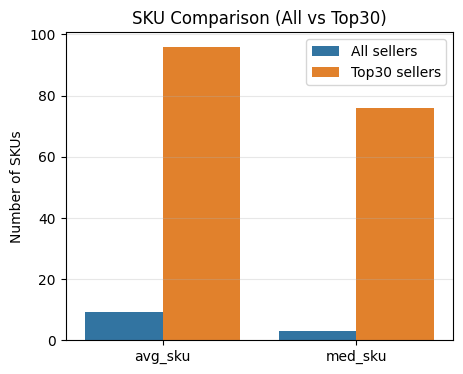

In [277]:
# SKU 비교용 DF
sku_df = summary[["group", "avg_sku", "med_sku"]].melt(
    id_vars="group",
    var_name="metric",
    value_name="value"
)

plt.figure(figsize=(5,4))
sns.barplot(data=sku_df, x="metric", y="value", hue="group")
plt.title("SKU Comparison (All vs Top30)")
plt.xlabel("")
plt.ylabel("Number of SKUs")
plt.legend(title="")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [280]:
# =====================
# Color Palette (동일)
# =====================
C_BLACK  = "#0B0B0B"
C_BLUE   = "#3E84DF"
C_ORANGE = "#FFA742"
GRID     = "rgba(0,0,0,0.08)"

# =====================
# Data prep (기존 로직 유지)
# =====================
sku_df = summary[["group", "avg_sku", "med_sku"]].melt(
    id_vars="group",
    var_name="metric",
    value_name="value"
)

# 그룹별 색상 매핑
group_color = {
    "All": C_BLUE,
    "Top30": C_ORANGE
}

# =====================
# Figure
# =====================
fig = go.Figure()

for g in sku_df["group"].unique():
    df_g = sku_df[sku_df["group"] == g]

    # ✅ Top30만 오렌지로 강제
    if "Top" in str(g):
        color = C_ORANGE
    else:
        color = C_BLUE

    fig.add_trace(
        go.Bar(
            x=df_g["metric"],
            y=df_g["value"],
            name=g,
            marker_color=color,
            text=[f"{int(v)}" for v in df_g["value"]],
            textposition="outside"
        )
    )


# =====================
# Layout (정사각형 / White BG)
# =====================
fig.update_layout(
    width=600,
    height=600,   # ✅ 정사각형
    title=dict(
        text="SKU Comparison (All vs Top30)",
        x=0.02,
        font=dict(size=20, color=C_BLACK)
    ),
    xaxis_title="",
    yaxis_title="Number of SKUs (log scale)",
    yaxis_type="log",          # ✅ 로그 스케일
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color=C_BLACK),
    margin=dict(l=80, r=40, t=80, b=70),
    legend=dict(
        title="",
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        xanchor="left",
        x=0
    ),
    bargap=0.35
)

fig.update_xaxes(
    showgrid=False,
    tickfont=dict(size=12)
)

fig.update_yaxes(
    showgrid=True,
    gridcolor=GRID,
    zeroline=False
)

fig.show()



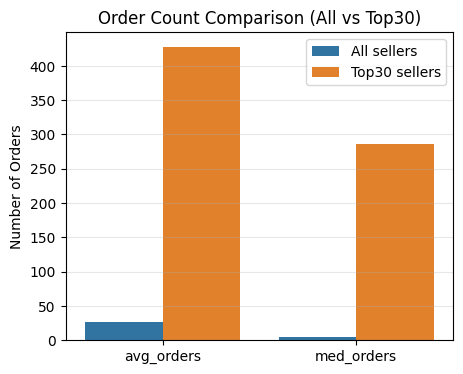

In [254]:
# 주문 수 비교용 DF
order_df = summary[["group", "avg_orders", "med_orders"]].melt(
    id_vars="group",
    var_name="metric",
    value_name="value"
)

plt.figure(figsize=(5,4))
sns.barplot(data=order_df, x="metric", y="value", hue="group")
plt.title("Order Count Comparison (All vs Top30)")
plt.xlabel("")
plt.ylabel("Number of Orders")
plt.legend(title="")
plt.grid(axis="y", alpha=0.3)
plt.show()


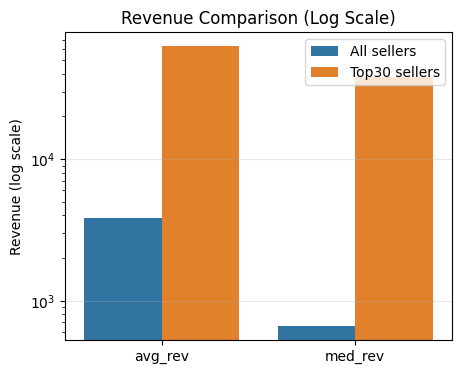

In [255]:
# 매출 비교용 DF
rev_df = summary[["group", "avg_rev", "med_rev"]].melt(
    id_vars="group",
    var_name="metric",
    value_name="value"
)

plt.figure(figsize=(5,4))
sns.barplot(data=rev_df, x="metric", y="value", hue="group")
plt.yscale("log")  # 🔥 중요
plt.title("Revenue Comparison (Log Scale)")
plt.xlabel("")
plt.ylabel("Revenue (log scale)")
plt.legend(title="")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [300]:
#3) SKU vs 매출 관계성 (상관 + 로그상관)
tmp = (
    seller_kpi
    .dropna(subset=["seller_sku_cnt", "seller_revenue"])
    .copy()
)

print("분석 대상 셀러 수:", tmp.shape[0])

# 2) 원본 스케일 상관관계
corr_spearman = tmp[["seller_sku_cnt", "seller_revenue"]].corr(method="spearman")
corr_pearson  = tmp[["seller_sku_cnt", "seller_revenue"]].corr(method="pearson")

print("\n[원본 기준 상관관계]")
print("Spearman")
display(corr_spearman)
print("Pearson")
display(corr_pearson)

# 3) 로그 변환
tmp["log_sku"] = np.log1p(tmp["seller_sku_cnt"])
tmp["log_rev"] = np.log1p(tmp["seller_revenue"])

# 4) 로그 스케일 상관관계
corr_log_spearman = tmp[["log_sku", "log_rev"]].corr(method="spearman")
corr_log_pearson  = tmp[["log_sku", "log_rev"]].corr(method="pearson")

print("\n[로그 변환 기준 상관관계]")
print("Spearman (log)")
display(corr_log_spearman)
print("Pearson (log)")
display(corr_log_pearson)

# 5) 한 줄 요약용 숫자
summary = {
    "spearman_raw": corr_spearman.iloc[0,1],
    "pearson_raw": corr_pearson.iloc[0,1],
    "spearman_log": corr_log_spearman.iloc[0,1],
    "pearson_log": corr_log_pearson.iloc[0,1],
}

print("\n[요약]")
for k, v in summary.items():
    print(f"{k}: {v:.3f}")


분석 대상 셀러 수: 1032

[원본 기준 상관관계]
Spearman


,seller_sku_cnt,seller_revenue
seller_sku_cnt,1.00000,0.78607
seller_revenue,0.78607,1.00000


Pearson


,seller_sku_cnt,seller_revenue
seller_sku_cnt,1.000000,0.737116
seller_revenue,0.737116,1.000000



[로그 변환 기준 상관관계]
Spearman (log)


,log_sku,log_rev
log_sku,1.00000,0.78607
log_rev,0.78607,1.00000


Pearson (log)


,log_sku,log_rev
log_sku,1.000000,0.790676
log_rev,0.790676,1.000000



[요약]
spearman_raw: 0.786
pearson_raw: 0.737
spearman_log: 0.786
pearson_log: 0.791


In [303]:
# =====================
# Color Palette (동일)
# =====================
C_BLACK  = "#0B0B0B"
C_BLUE   = "#3E84DF"
C_ORANGE = "#FFA742"
GRID     = "rgba(0,0,0,0.08)"

# =====================
# Outlier 제거
# =====================
filt = (tmp["seller_sku_cnt"] <= 200) & (tmp["seller_revenue"] <= 60_000)
df = tmp.loc[filt].copy()

x = df["seller_sku_cnt"]
y = df["seller_revenue"]

# =====================
# 추세선 (OLS)
# =====================
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)

x_line = np.linspace(x.min(), x.max(), 200)
y_line = trend(x_line)

# =====================
# Figure
# =====================
fig = go.Figure()

# ① Scatter (Filtered points)
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode="markers",
        marker=dict(
            size=7,
            color=C_BLUE,
            opacity=0.45
        ),
        hovertemplate=(
            "SKUs: %{x}<br>"
            "Revenue: %{y:,.0f}<extra></extra>"
        ),
        name="Sellers (Filtered)"
    )
)

# ② Trend line
fig.add_trace(
    go.Scatter(
        x=x_line,
        y=y_line,
        mode="lines",
        line=dict(color=C_ORANGE, width=3),
        name="Trend"
    )
)

# =====================
# Layout (정사각형 / White BG)
# =====================
fig.update_layout(
    width=650,
    height=650,  # 정사각형
    title=dict(
        text="SKU vs Revenue (Filtered: SKU ≤ 200, Revenue ≤ 100k)",
        x=0.02,
        font=dict(size=20, color=C_BLACK)
    ),
    xaxis_title="Number of SKUs",
    yaxis_title="Revenue",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color=C_BLACK),
    margin=dict(l=90, r=40, t=80, b=80),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        xanchor="left",
        x=0
    )
)

fig.update_xaxes(
    showgrid=True,
    gridcolor=GRID,
    zeroline=False,
    range=[0, 200]          # 👈 가독성 확실
)

fig.update_yaxes(
    showgrid=True,
    gridcolor=GRID,
    zeroline=False,
    tickformat=",.0f",
    range=[0, 60_000]      # 👈 가독성 확실
)

fig.show()



In [283]:
tmp2 = seller_kpi.copy()

# SKU 분위수 10구간(중복 구간 방지)
tmp2["sku_bin"] = pd.qcut(tmp2["seller_sku_cnt"], q=10, duplicates="drop")

sku_bin_table = (tmp2.groupby("sku_bin", as_index=False)
                 .agg(
                     sellers=("seller_id", "nunique"),
                     sku_min=("seller_sku_cnt","min"),
                     sku_max=("seller_sku_cnt","max"),
                     avg_sku=("seller_sku_cnt","mean"),
                     avg_rev=("seller_revenue","mean"),
                     med_rev=("seller_revenue","median")
                 ))

sku_bin_table


C:\Users\mg441\AppData\Local\Temp\ipykernel_11148\3698801258.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,sku_bin,sellers,sku_min,sku_max,avg_sku,avg_rev,med_rev
0,"(0.999, 2.0]",494,1,2,1.327935,549.574391,215.755000
1,"(2.0, 3.0]",83,3,3,3.000000,989.553076,611.680000
2,"(3.0, 4.0]",81,4,4,4.000000,2735.607731,877.110000
3,"(4.0, 6.0]",90,5,6,5.522222,2557.625554,1219.775000
4,"(6.0, 9.0]",81,7,9,7.987654,5531.969227,2465.090000
5,"(9.0, 17.0]",102,10,17,12.990196,4956.557938,3559.815000
6,"(17.0, 317.0]",101,18,317,57.257426,21666.112984,9781.923802


In [305]:
# =====================
# Color Palette (고정)
# =====================
COLOR_BLUE   = "#3E84DF"
COLOR_ORANGE = "#FFA742"
COLOR_BLACK  = "#1f1f1f"
COLOR_GRID   = "rgba(0,0,0,0.08)"

# =====================
# Data prep
# =====================
t = sku_bin_table.sort_values("sku_min").reset_index(drop=True).copy()
t["sku_label"] = t["sku_max"].apply(lambda x: f"~{int(x)}")

# 임계 구간 (SKU 18)
threshold_idx = t[t["sku_min"] <= 18].index.max()
threshold_label = t.loc[threshold_idx, "sku_label"]

# 강조할 구간: 임계 이후 전체
ramp_start = threshold_label
ramp_end = t["sku_label"].iloc[-1]

# =====================
# Figure
# =====================
fig = go.Figure()

# 0) "구간" 강조(세로 밴드) — 지점 강조 X
fig.add_vrect(
    x0=ramp_start,
    x1=ramp_end,
    fillcolor="rgba(255,167,66,0.18)",  # ORANGE alpha
    line_width=0,
    layer="below"
)

# 1) 임계 이전(블루) 구간 라인
fig.add_trace(
    go.Scatter(
        x=t.loc[:threshold_idx, "sku_label"],
        y=t.loc[:threshold_idx, "med_rev"],
        mode="lines+markers",
        line=dict(color=COLOR_BLUE, width=2),
        marker=dict(size=9, color=COLOR_BLUE, opacity=0.65),
        hovertemplate="SKU Range: %{x}<br>Median Revenue: %{y:,.0f}<extra></extra>",
        showlegend=False
    )
)

# 2) 임계 이후(오렌지) 구간 라인 — 구간 자체를 더 강하게
fig.add_trace(
    go.Scatter(
        x=t.loc[threshold_idx:, "sku_label"],
        y=t.loc[threshold_idx:, "med_rev"],
        mode="lines+markers",
        line=dict(color=COLOR_ORANGE, width=4),  # ✅ 두껍게
        marker=dict(size=11, color=COLOR_ORANGE, opacity=0.95),
        hovertemplate="SKU Range: %{x}<br>Median Revenue: %{y:,.0f}<extra></extra>",
        showlegend=False
    )
)

# 3) 구간 라벨(텍스트만) — 화살표/지점 없이
fig.add_annotation(
    x=ramp_start,
    y=1.03,
    xref="x",
    yref="paper",
    text="임계 이후 매출 급상승 구간",
    showarrow=False,
    font=dict(size=12, color=COLOR_BLACK),
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="rgba(0,0,0,0.12)",
    borderwidth=1,
    xanchor="left"
)

# =====================
# Layout (16:4 PPT)
# =====================
fig.update_layout(
    width=800,
    height=400,
    title=dict(
        text="Median Revenue by SKU Bin (Home & Living)",
        x=0.01,
        font=dict(size=20, color=COLOR_BLACK)
    ),
    xaxis_title="SKU Range",
    yaxis_title="Median Revenue",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color=COLOR_BLACK),
    margin=dict(l=80, r=40, t=70, b=60),
)

fig.update_xaxes(
    showgrid=True,
    gridcolor=COLOR_GRID,
    zeroline=False,
    categoryorder="array",
    categoryarray=t["sku_label"].tolist(),
)

fig.update_yaxes(
    showgrid=True,
    gridcolor=COLOR_GRID,
    zeroline=False,
    tickformat=",.0f",
)

fig.show()


In [237]:
pip install plotly



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [286]:
t = sku_bin_table.sort_values("sku_min").copy()
t["med_rev_prev"] = t["med_rev"].shift(1)
t["med_rev_jump"] = t["med_rev"] - t["med_rev_prev"]

# 가장 크게 뛰는 구간
best_row = t.sort_values("med_rev_jump", ascending=False).head(1)
best_row
row = best_row.iloc[0]
threshold_sku = int(row["sku_min"])

conclusion = f"Home & Living에서 SKU가 {threshold_sku}개 이상인 구간부터 중앙 매출이 가장 크게 점프한다(임계 SKU 후보)."
conclusion

'Home & Living에서 SKU가 18개 이상인 구간부터 중앙 매출이 가장 크게 점프한다(임계 SKU 후보).'

In [287]:
# ============================================================
# SKU 임계점(18개) 전후 비교 분석
# ============================================================

import numpy as np
import pandas as pd

THRESHOLD = 18

df = seller_kpi.copy()

# 1) SKU 기준 그룹 나누기
df["sku_group"] = np.where(
    df["seller_sku_cnt"] < THRESHOLD,
    f"< {THRESHOLD}",
    f">= {THRESHOLD}"
)

# 2) 그룹별 핵심 지표 비교
summary = (
    df.groupby("sku_group", as_index=False)
      .agg(
          sellers=("seller_id", "nunique"),
          avg_sku=("seller_sku_cnt", "mean"),
          med_sku=("seller_sku_cnt", "median"),
          avg_rev=("seller_revenue", "mean"),
          med_rev=("seller_revenue", "median"),
          avg_orders=("seller_order_cnt", "mean"),
          med_orders=("seller_order_cnt", "median"),
      )
)

summary


,sku_group,sellers,avg_sku,med_sku,avg_rev,med_rev,avg_orders,med_orders
0,< 18,931,3.972073,2.0,1889.421695,508.630000,11.832438,4.0
1,>= 18,101,57.257426,36.0,21666.112984,9781.923802,160.683168,83.0


In [288]:
# ============================================================
# 상위 10% 매출 셀러의 SKU 중위값(median)
# ============================================================

# 1) 분석용 데이터
tmp = seller_kpi.dropna(subset=["seller_revenue", "seller_sku_cnt"]).copy()

# 2) 상위 10% 매출 기준 (80퍼센타일)
rev_thr = tmp["seller_revenue"].quantile(0.90)

# 3) 상위 10% 매출 셀러 추출
top10pct = tmp[tmp["seller_revenue"] >= rev_thr]

# 4) SKU 중위값
median_sku = int(top10pct["seller_sku_cnt"].median())

# 5) 확인용 출력
print("상위 10% 매출 기준 매출액:", rev_thr)
print("상위 10% 셀러 수:", top10pct.shape[0])
print("SKU 중위값:", median_sku)

# 6) 결론 문장
f"Home & Living에서 매출 상위 10% 셀러의 SKU 중위값은 {median_sku}개이다."


상위 10% 매출 기준 매출액: 8011.512029688166
상위 10% 셀러 수: 104
SKU 중위값: 29


'Home & Living에서 매출 상위 10% 셀러의 SKU 중위값은 29개이다.'

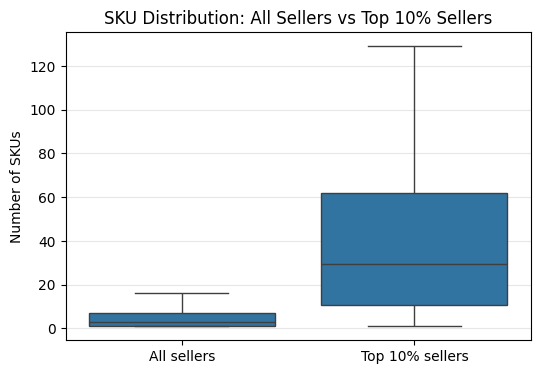

In [289]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_all = tmp.copy()
df_all["group"] = "All sellers"

df_top10pct = top10pct.copy()
df_top10pct["group"] = "Top 10% sellers"

df_plot = pd.concat([df_all, df_top10pct], axis=0)

plt.figure(figsize=(6,4))
sns.boxplot(
    data=df_plot,
    x="group",
    y="seller_sku_cnt",
    showfliers=False
)
plt.title("SKU Distribution: All Sellers vs Top 10% Sellers")
plt.xlabel("")
plt.ylabel("Number of SKUs")
plt.grid(axis="y", alpha=0.3)
plt.show()


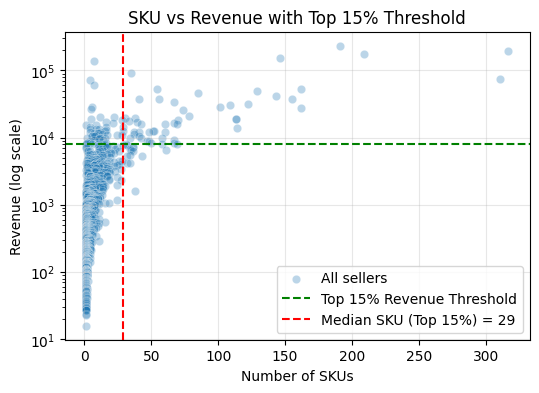

In [290]:
plt.figure(figsize=(6,4))

sns.scatterplot(
    data=tmp,
    x="seller_sku_cnt",
    y="seller_revenue",
    alpha=0.3,
    label="All sellers"
)

plt.axhline(
    rev_thr,
    color="green",
    linestyle="--",
    label="Top 15% Revenue Threshold"
)

plt.axvline(
    median_sku,
    color="red",
    linestyle="--",
    label=f"Median SKU (Top 15%) = {median_sku}"
)

plt.yscale("log")
plt.xlabel("Number of SKUs")
plt.ylabel("Revenue (log scale)")
plt.title("SKU vs Revenue with Top 15% Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [291]:
# order → customer_id
hl = hl.merge(
    orders_fix[["order_id", "customer_id"]],
    on="order_id",
    how="left"
)

# customer_id → customer_unique_id
hl = hl.merge(
    customers[["customer_id", "customer_unique_id"]],
    on="customer_id",
    how="left"
)

hl.head()

top30_sellers = (
    seller_kpi
    .sort_values("seller_revenue", ascending=False)
    .head(30)["seller_id"]
)

hl_top30 = hl[hl["seller_id"].isin(top30_sellers)].copy()

hl_top30[["seller_id","order_id","customer_unique_id"]].head()

# seller - customer 단위 구매 횟수
seller_customer = (
    hl_top30
    .groupby(["seller_id", "customer_unique_id"], as_index=False)
    .agg(order_cnt=("order_id", "nunique"))
)

seller_repeat = (
    seller_customer
    .groupby("seller_id", as_index=False)
    .agg(
        customers=("customer_unique_id", "nunique"),
        repeat_customers=("order_cnt", lambda x: (x >= 2).sum())
    )
)

seller_repeat["repeat_rate"] = (
    seller_repeat["repeat_customers"] / seller_repeat["customers"]
)

seller_repeat.head()

# order_id ↔ seller_id 매핑
order_seller = (
    hl_top30[["order_id", "seller_id"]]
    .drop_duplicates()
)

review_seller = (
    reviews_dedup
    .merge(order_seller, on="order_id", how="inner")
)

seller_review = (
    review_seller
    .groupby("seller_id", as_index=False)
    .agg(
        review_cnt=("review_score", "count"),
        avg_review_score=("review_score", "mean")
    )
)

seller_review.head()

seller_top30_analysis = (
    seller_kpi[["seller_id","seller_revenue"]]
    .merge(seller_review, on="seller_id", how="left")
    .merge(seller_repeat, on="seller_id", how="left")
)

seller_top30_analysis.head(31)


,seller_id,seller_revenue,review_cnt,avg_review_score,customers,repeat_customers,repeat_rate
0,7c67e1448b00f6e969d365cea6b010ab,233670.029030,953.0,3.504722,943.0,11.0,0.011665
1,4a3ca9315b744ce9f8e9374361493884,197437.757095,1501.0,3.869420,1500.0,6.0,0.004000
2,da8622b14eb17ae2831f4ac5b9dab84a,173888.346444,1075.0,4.111628,1035.0,33.0,0.031884
3,1025f0e2d44d7041d6cf58b6550e0bfa,151377.954953,838.0,3.984487,828.0,14.0,0.016908
4,1f50f920176fa81dab994f9023523100,136425.697757,1371.0,4.142232,1358.0,15.0,0.011046
5,955fee9216a65b617aa5c0531780ce60,92588.450000,670.0,4.146269,670.0,4.0,0.005970
6,cca3071e3e9bb7d12640c9fbe2301306,75257.630536,675.0,3.869630,668.0,10.0,0.014970
7,a1043bafd471dff536d0c462352beb48,71208.660000,392.0,4.227041,390.0,2.0,0.005128
8,37be5a7c751166fbc5f8ccba4119e043,59918.330000,264.0,4.325758,261.0,4.0,0.015326
9,77530e9772f57a62c906e1c21538ab82,53331.556231,310.0,4.164516,303.0,4.0,0.013201


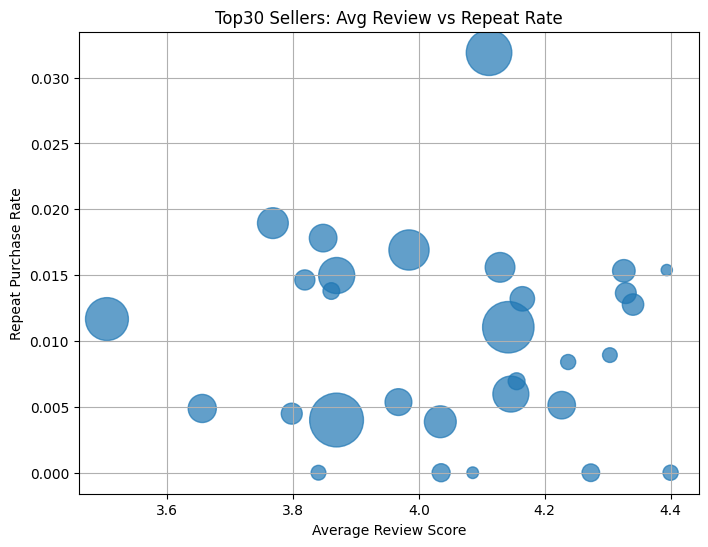

In [292]:
tmp = seller_top30_analysis.dropna(
    subset=["avg_review_score","repeat_rate"]
)

tmp[["avg_review_score","repeat_rate"]].corr(method="spearman")
tmp[["avg_review_score","repeat_rate"]].corr(method="pearson")

plt.figure(figsize=(8,6))
plt.scatter(
    tmp["avg_review_score"],
    tmp["repeat_rate"],
    s=tmp["review_cnt"],
    alpha=0.7
)
plt.xlabel("Average Review Score")
plt.ylabel("Repeat Purchase Rate")
plt.title("Top30 Sellers: Avg Review vs Repeat Rate")
plt.grid(True)
plt.show()


In [293]:
# 1) order_items + product_fix(영문 카테고리/industry) 붙이기
hl_items = (
    order_items
    .merge(
        products_fix[["product_id", "industry", "product_category_name_english"]],
        on="product_id",
        how="left"
    )
    .query("industry == 'Home & Living'")
)

# 2) 카테고리별 집계 (판매건수 + 누적 매출)
cat_perf = (
    hl_items
    .groupby("product_category_name_english")
    .agg(
        order_cnt=("order_id", "nunique"),   # 주문 건수(중복 제거)
        item_cnt=("order_item_id", "count"), # 판매 수량(라인아이템 기준)
        total_sales=("price", "sum")         # 매출(상품 price 합)
    )
    .reset_index()
)

# 보기 좋게 정렬 (주문건수 기준)
cat_perf = cat_perf.sort_values("order_cnt", ascending=False)
cat_perf.head(10)


,product_category_name_english,order_cnt,item_cnt,total_sales
0,bed_bath_table,9417,11115,1036988.68
1,furniture_decor,6449,8334,729762.49
5,housewares,5884,6964,632248.66
3,garden_tools,3518,4347,485256.46
6,office_furniture,1273,1691,273960.70
4,home_construction,490,604,83088.12
2,furniture_living_room,422,503,68916.56


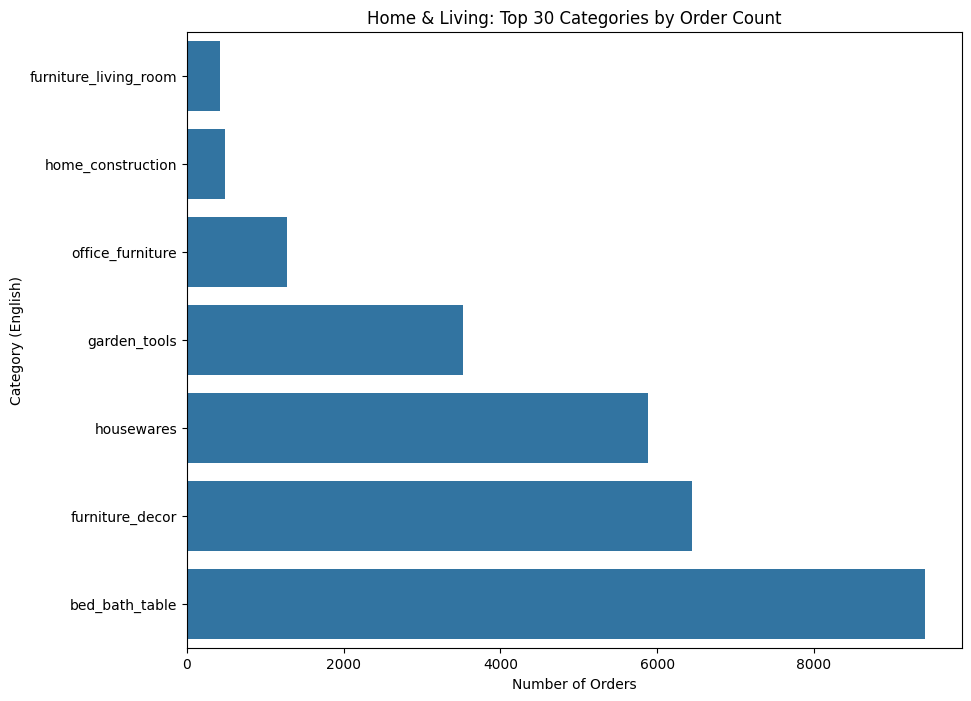

In [294]:
topN = 30  # 필요하면 15/20/50으로 조절
plot_df = cat_perf.head(topN).sort_values("order_cnt", ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=plot_df, x="order_cnt", y="product_category_name_english")
plt.title(f"Home & Living: Top {topN} Categories by Order Count")
plt.xlabel("Number of Orders")
plt.ylabel("Category (English)")
plt.show()


In [295]:
cat_rev = (
    hl_items
    .groupby("product_category_name_english")
    .agg(
        total_sales=("price", "sum"),          # 누적 매출
        order_cnt=("order_id", "nunique"),     # 주문 건수
        item_cnt=("order_item_id", "count")    # 판매 수량
    )
    .reset_index()
)

# 매출 기준 정렬
cat_rev = cat_rev.sort_values("total_sales", ascending=False)
cat_rev.head(30)


,product_category_name_english,total_sales,order_cnt,item_cnt
0,bed_bath_table,1036988.68,9417,11115
1,furniture_decor,729762.49,6449,8334
5,housewares,632248.66,5884,6964
3,garden_tools,485256.46,3518,4347
6,office_furniture,273960.70,1273,1691
4,home_construction,83088.12,490,604
2,furniture_living_room,68916.56,422,503


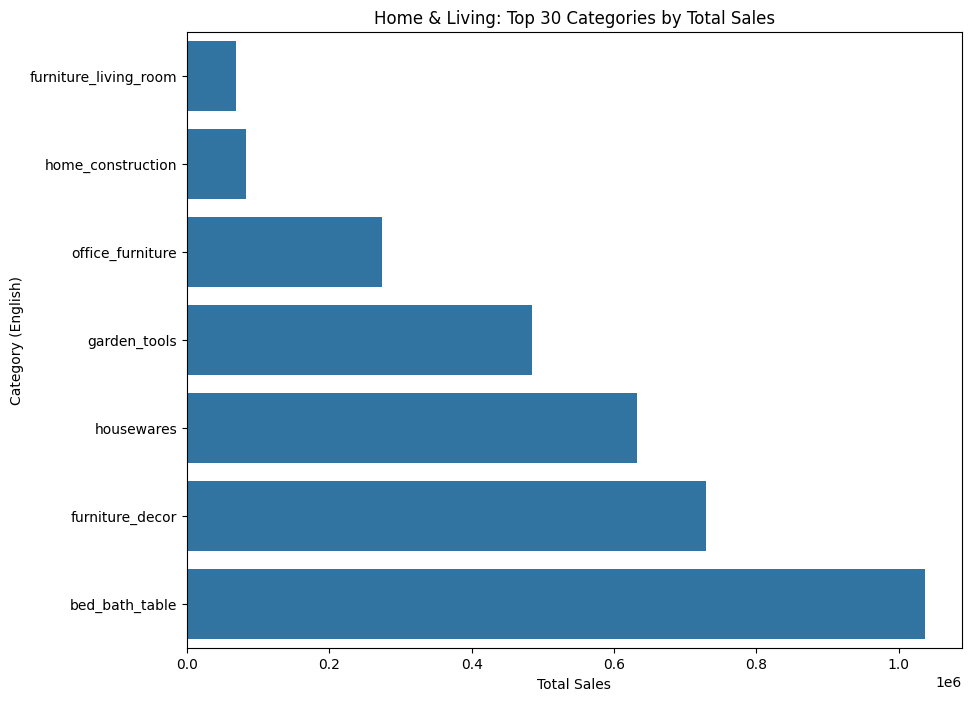

In [296]:
topN = 30
plot_df = cat_rev.head(topN).sort_values("total_sales", ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=plot_df,
    x="total_sales",
    y="product_category_name_english"
)
plt.title(f"Home & Living: Top {topN} Categories by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Category (English)")
plt.show()

In [298]:
# =====================
# Color Palette (동일)
# =====================
C_BLACK = "#0B0B0B"
C_BLUE  = "#3E84DF"
C_GRAY  = "#D3D3D3"
GRID    = "rgba(0,0,0,0.15)"  # 눈금 강조용

# =====================
# Highlight categories
# =====================
highlight_cats = [
    "housewares",
    "furniture_decor",
    "bed_bath_table"
]

# =====================
# Data prep (기존 로직 유지)
# =====================
plot_df = cat_perf.head(30).sort_values("order_cnt", ascending=True)

colors = [
    C_BLUE if c in highlight_cats else C_GRAY
    for c in plot_df["product_category_name_english"]
]

# =====================
# Figure
# =====================
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=plot_df["product_category_name_english"],
        x=plot_df["order_cnt"],
        orientation="h",
        marker_color=colors,
        hovertemplate=(
            "Category: %{y}<br>"
            "Orders: %{x:,.0f}<extra></extra>"
        ),
        showlegend=False
    )
)

# =====================
# 별(★) Annotation (강조 카테고리)
# =====================
max_x = plot_df["order_cnt"].max()

for _, row in plot_df.iterrows():
    if row["product_category_name_english"] in highlight_cats:
        fig.add_annotation(
            x=row["order_cnt"] + max_x * 0.02,
            y=row["product_category_name_english"],
            text="★",
            showarrow=False,
            font=dict(size=16, color=C_BLACK),
            xanchor="left",
            yanchor="middle"
        )

# =====================
# Layout (정사각형 / White BG / 눈금 강조)
# =====================
fig.update_layout(
    width=700,
    height=700,  # ✅ 정사각형
    title=dict(
        text="Home & Living: Core Categories Driving Orders",
        x=0.02,
        font=dict(size=20, color=C_BLACK)
    ),
    xaxis_title="Number of Orders",
    yaxis_title="Category (English)",
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color=C_BLACK),
    margin=dict(l=180, r=40, t=80, b=80),
)

# =====================
# Axes (눈금 & 그리드 강조)
# =====================
fig.update_xaxes(
    showgrid=True,
    gridcolor=GRID,
    zeroline=False,
    ticks="outside",          # ✅ 눈금 표시
    ticklen=8,                # ✅ 눈금 길이
    tickwidth=1.5,
    tickcolor=C_BLACK,
    tickformat=",.0f"
)

fig.update_yaxes(
    showgrid=False,
    ticks="outside",
    tickfont=dict(size=12)
)

fig.show()